## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Reading Dataset

In [2]:
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [3]:
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


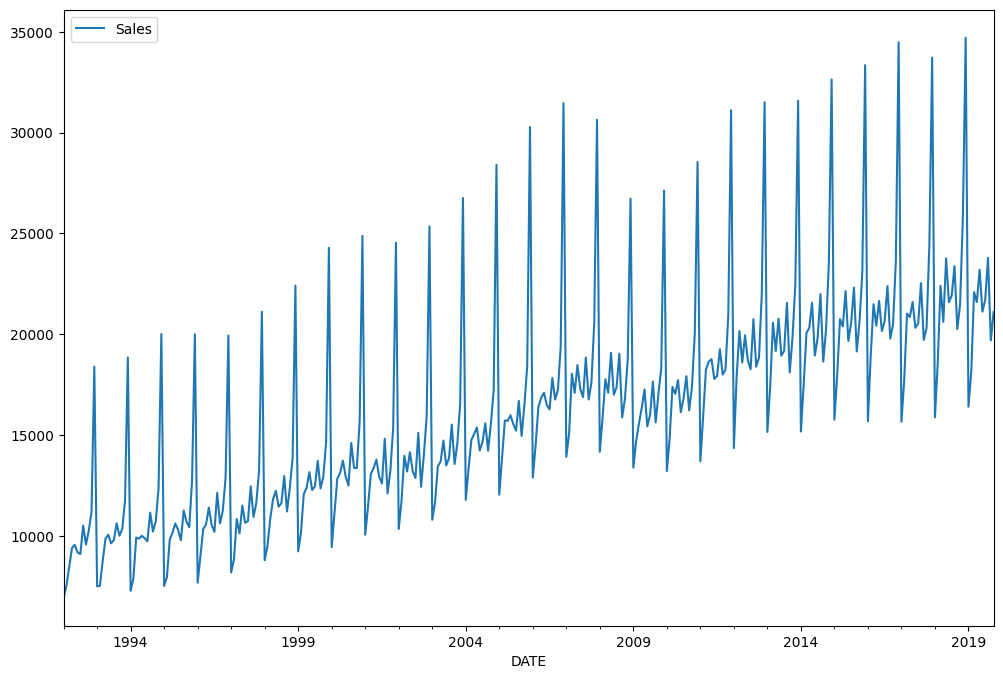

In [4]:
df.plot(figsize=(12,8));

## Train Test Split

In [5]:
len(df)

334

In [6]:
len(df) - 18

316

In [7]:
test_size = 18
test_index = len(df) - test_size

In [8]:
train_set = df.iloc[:test_index]
test_set = df.iloc[test_index:]

In [9]:
len(test_set)

18

## Normalization

In [10]:
scaler = MinMaxScaler()

In [11]:
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)

## Time Series Generator

In [12]:
len(test_set)

18

In [13]:
length = 12
batch_size = 1

generator = TimeseriesGenerator(
    data=train_set_scaled,
    targets=train_set_scaled,
    length=length,
    batch_size=batch_size
)

In [14]:
len(train_set_scaled)

316

In [15]:
len(generator)

304

In [16]:
X, y = generator[0]

In [17]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [18]:
y

array([[0.02047633]])

In [19]:
train_set_scaled

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633],
       [0.02127505],
       [0.06636654],
       [0.10633895],
       [0.11345484],
       [0.09791606],
       [0.10368864],
       [0.13396747],
       [0.11163956],
       [0.12372931],
       [0.17506535],
       [0.43250799],
       [0.0124165 ],
       [0.03499855],
       [0.10829945],
       [0.10641156],
       [0.11149434],
       [0.10728289],
       [0.10154662],
       [0.1531731 ],
       [0.11904589],
       [0.13767064],
       [0.19663085],
       [0.47480395],
       [0.02105722],
       [0.03714058],
       [0.10445106],
       [0.11726692],
       [0.13367703],
       [0.12209556],
       [0.10332559],
       [0.1570578 ],
       [0.13694453],
       [0.12710572],
       [0.21104415],
       [0.474

## Creating the Model

In [20]:
num_of_features = 1

In [21]:
model = Sequential()

model.add(LSTM(units=100 , activation='relu', input_shape=(length, num_of_features)))
model.add(Dense(units=1))

model.compile(
    optimizer='adam',
    loss='mse'
)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2
)

In [24]:
validation_generator = TimeseriesGenerator(
    data=test_set_scaled,
    targets=test_set_scaled,
    length=length,
    batch_size=batch_size
)

In [25]:
model.fit(
    generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0243 - val_loss: 0.0026
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0180 - val_loss: 0.0075
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - val_loss: 0.0158


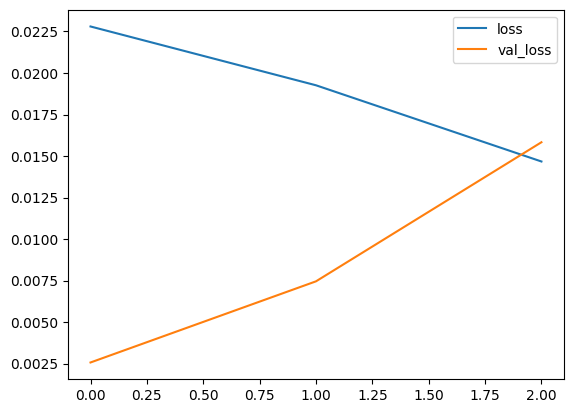

In [26]:
losses = pd.DataFrame(model.history.history)
losses.plot();

## Evaluation on Test Data

In [27]:
test_predictions = []

first_eval_batch = train_set_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, num_of_features))

for i in range(len(test_set)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


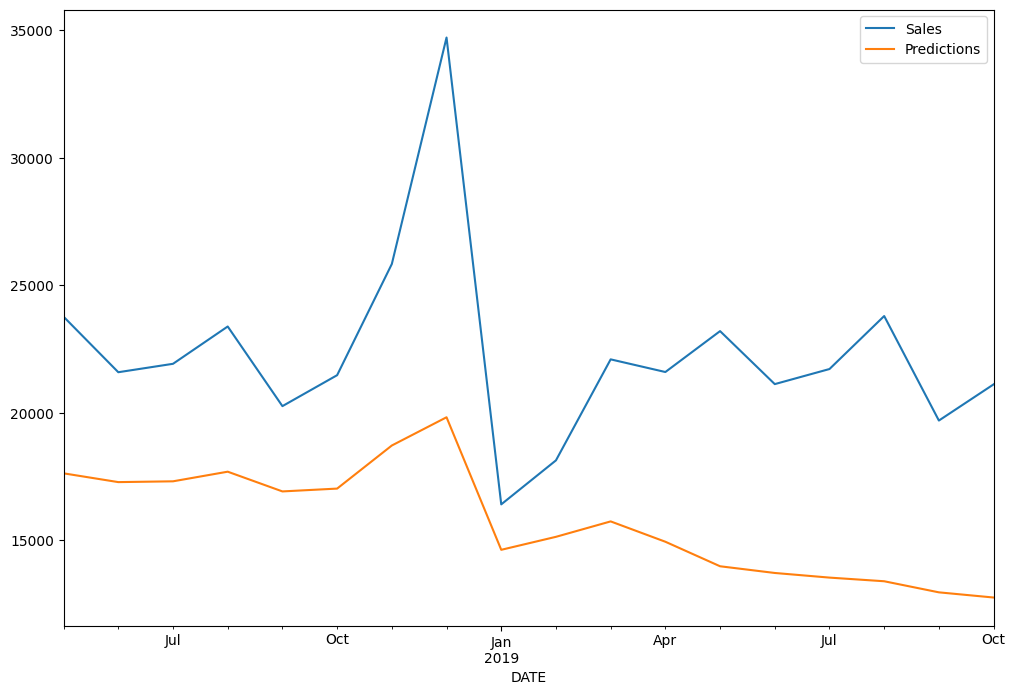

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)
test_set['Predictions'] = true_predictions
test_set.plot(figsize=(12,8));

## Forecast into Unknown Future

In [29]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [30]:
length = 12
batch_size = 1

In [31]:
generator = TimeseriesGenerator(
    data=scaled_full_data,
    targets=scaled_full_data,
    length=length,
    batch_size=batch_size
)

In [32]:
num_of_features = 1

In [33]:
model = Sequential()

model.add(LSTM(units=100 , activation='relu', input_shape=(length, num_of_features)))
model.add(Dense(units=1))

model.compile(
    optimizer='adam',
    loss='mse'
)

In [34]:
model.fit(
    generator,
    epochs=8,
)

Epoch 1/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0455
Epoch 2/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170
Epoch 3/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 4/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047
Epoch 5/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037
Epoch 6/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016
Epoch 7/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018
Epoch 8/8
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2527e-04


In [35]:
forecast = []
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, num_of_features))

for i in range(periods):
    current_prediction = model.predict(current_batch)[0]
    forecast.append(current_prediction)
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [36]:
forecast = full_scaler.inverse_transform(forecast)

In [37]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [38]:
forecast

array([[27793.32674837],
       [38340.65977383],
       [18592.9883728 ],
       [20119.87768984],
       [23817.44622707],
       [23313.69614029],
       [24996.93464661],
       [22968.50811386],
       [23597.44513369],
       [25764.32589531],
       [21972.06567526],
       [23403.57975245]])

In [39]:
forecast_index = pd.date_range(
    start='2019-11-01', 
    periods=periods,
    freq="MS"
)

forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [40]:
forecast_df = pd.DataFrame(
    data=forecast,
    index=forecast_index,
    columns=['Forecast']
)

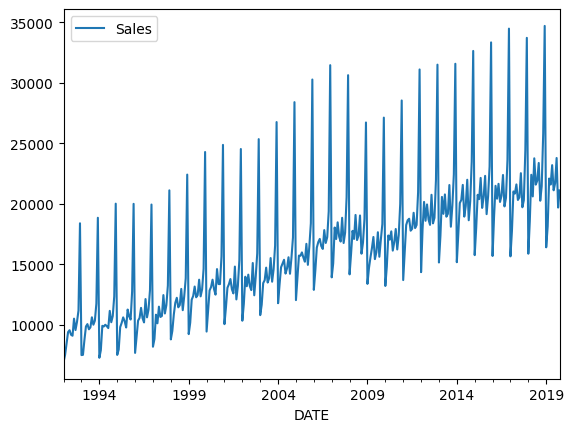

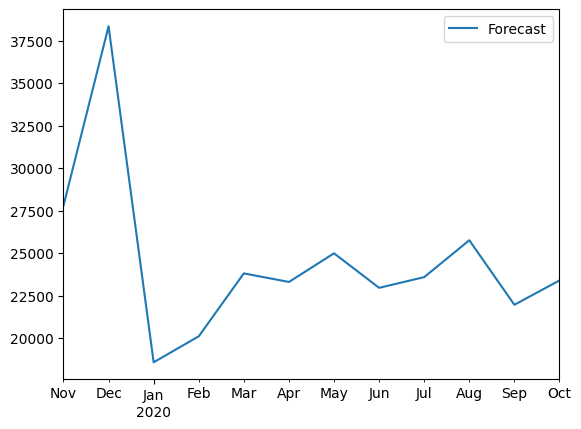

In [41]:
df.plot()
forecast_df.plot();

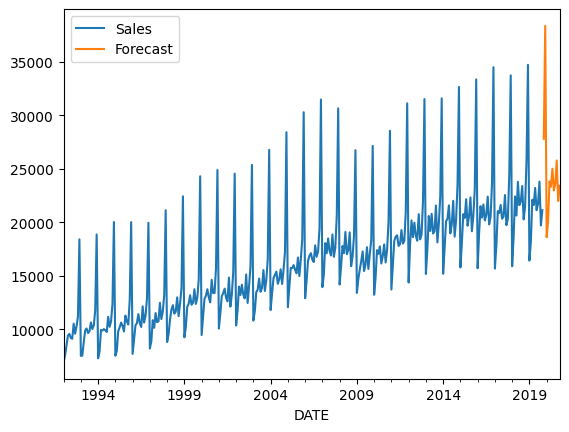

In [42]:
ax = df.plot()
forecast_df.plot(ax=ax);

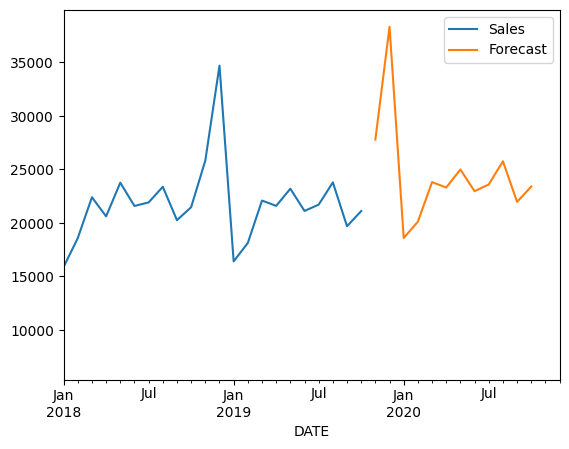

In [43]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01');